In [12]:
import pandas as df
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path

os.chdir(Path(sys.path[0]).parent)
import modules.utils as utils

import torch
import torch.nn as nn
import torch.nn.functional as F

## Preprocess the data

In [13]:
Directory = 'data'
u_ds = utils.concatenate_time(Directory, 'u')
v_ds = utils.concatenate_time(Directory, 'v')
w_ds = utils.concatenate_time(Directory, 'w')
theta_ds = utils.concatenate_time(Directory, 'theta')
assert u_ds.shape == v_ds.shape == w_ds.shape == theta_ds.shape, 'u,v,w,theta have different shape'

In [14]:
wtheta_ds = w_ds*theta_ds

In [15]:
u_coarse = utils.coarse_array(u_ds, 32)
v_coarse = utils.coarse_array(v_ds, 32)
w_coarse = utils.coarse_array(w_ds, 32)
u_coarse.shape

(1, 4, 16, 16)

In [26]:
tke_ds = utils.coarse_array(u_ds*u_ds, 32) - u_coarse*u_coarse + utils.coarse_array(v_ds*v_ds, 32) - v_coarse*v_coarse + utils.coarse_array(w_ds*w_ds, 32) - w_coarse*w_coarse
tke_ds.shape

(1, 4, 16, 16)

In [17]:
# get vector of altitudes for each y,x point
u_samples = np.zeros((u_coarse.shape[0]*u_coarse.shape[2]*u_coarse.shape[3], u_coarse.shape[1]))

for t in range(u_coarse.shape[0]):
    for i in range(u_coarse.shape[2]):
        for j in range(u_coarse.shape[3]):
            u_samples[t*u_coarse.shape[2]*u_coarse.shape[3] + i*u_coarse.shape[3] + j] = u_coarse[t,:,i,j]


In [27]:
utils.variable_samples(u_ds, 32).shape

(256, 4)

In [19]:
variables = ['u', 'v', 'w', 'theta']  # add 's' 
input_ds = utils.input_dataset(Directory, variables, 32)

In [20]:
input_ds.shape

(256, 16)

In [28]:
tke_in = utils.variable_samples(tke_ds, 1)
output_ds = utils.variable_samples(wtheta_ds, 32)
tke_in.shape

(256, 4)

In [29]:
tot_ds = np.concatenate((np.concatenate((input_ds,tke_in), axis=1), output_ds), axis=1)
tot_ds.shape

(256, 24)

## First NN

In [30]:
# define a three layer linear neural network with one hidden layer, input size is 16 and output size is 4
class LinNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LinNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

learning_rate = 0.001
model = LinNet(20,32,4)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
# split input_ds and output_ds into training and validation sets
train, test = utils.split_train_val(tot_ds,32)
input_train, output_train, input_val, output_val = train[:,:20], train[:,20:], test[:,:20], test[:,20:]
input_val.shape
#tot_ds.shape

(64, 20)

In [29]:
input = torch.from_numpy(input_train).float()
output = torch.from_numpy(output_train).float()
input_batch = input[batch_size:2*batch_size,:]
output_batch = output[batch_size:2*batch_size,:]
F.mse_loss(model(input_batch), output_batch, reduction='sum')

tensor(1.9449, grad_fn=<MseLossBackward>)

In [33]:
# train the model
nb_epochs = 100
losses=[]
batch_size = 32
model.train()

for epoch in range(nb_epochs):
    tot_losses=0
    for i in np.random.permutation(input_train.shape[0]//batch_size):
        # convert numpy array to torch tensor
        input = torch.from_numpy(input_train).float()
        output = torch.from_numpy(output_train).float()
        loss=0

        input_batch = input[i*batch_size:(i+1)*batch_size,:]
        output_batch = output[i*batch_size:(i+1)*batch_size,:]
        optimizer.zero_grad()
        # forward pass
        output_pred = model(input_batch)
        # compute loss
        loss += F.mse_loss(output_pred, output_batch, reduction='sum')
        tot_losses += loss.item()
        # backward pass
        loss.backward()
        optimizer.step()
    losses.append(tot_losses/(input_train.shape[0]//batch_size))
    if (epoch+1)%10==0:
        print('Epoch [{}/{}], Loss: {:.6f}'.format(epoch+1, nb_epochs, tot_losses/(input_train.shape[0]//batch_size)))

Epoch [10/100], Loss: 2.651362
Epoch [20/100], Loss: 1.909033
Epoch [30/100], Loss: 1.428063
Epoch [40/100], Loss: 0.829636
Epoch [50/100], Loss: 0.516530
Epoch [60/100], Loss: 0.379457
Epoch [70/100], Loss: 0.322395
Epoch [80/100], Loss: 0.259224
Epoch [90/100], Loss: 0.224755
Epoch [100/100], Loss: 0.218070


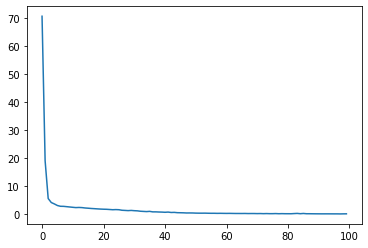

In [34]:
plt.plot(losses)

In [35]:
# test the model

# convert numpy array to torch tensor
input_test = torch.from_numpy(input_val).float()
output_test = torch.from_numpy(output_val).float()
predictions= torch.zeros(output_test.shape)
tot_losses=0

model.eval()
# prediction
output_pred = model(input_test)
# compute loss
loss = F.mse_loss(output_pred, output_test, reduction='sum')

print('Test loss: {:.6f}'.format(loss*batch_size/input_test.shape[0]))

Test loss: 0.190213


In [38]:
print(output_pred[-5:])
print(output_test[-5:])

tensor([[0.2030, 0.2359, 0.2534, 0.2327],
        [0.2530, 0.2538, 0.2637, 0.2726],
        [0.3081, 0.2995, 0.2957, 0.3282],
        [0.2327, 0.2537, 0.2437, 0.2612],
        [0.1599, 0.1813, 0.1876, 0.1819]], grad_fn=<SliceBackward>)
tensor([[0.1177, 0.1207, 0.1238, 0.1267],
        [0.2500, 0.2542, 0.2579, 0.2616],
        [0.3858, 0.3905, 0.3950, 0.3996],
        [0.2752, 0.2856, 0.2963, 0.3070],
        [0.1327, 0.1382, 0.1438, 0.1497]])
